## Load Dataset

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
# Set seed
np.random.seed(42)
random.seed(42)
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.linear_model import Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor

In [107]:
#data = pd.read_csv('../data/data.csv')
data= pd.read_csv('../data/data_engineered.csv')
data.head()
data.shape

(312, 40)

### Features and Target Variable

In [109]:
# Define features (X) and target variable (y)

# columns to exclude: population-related and crime-related features
crime_related_columns = [
    'count:__crimes_against_society', 
    'count:__fraud_and_other_financial_crimes', 
    'count:__property_crime', 
    'count:__violent_crime',
    'rate:__crimes_against_society', 
    'rate:__fraud_and_other_financial_crimes', 
    'rate:__property_crime', 
    'rate:__violent_crime',
    'total_crime_count',
    'total_crime_rate',
    'log_total_crime_rate'
]

population_related_columns = [
    'total_pop',
    'white_pop',
    'black_pop',
    'hispanic_pop',
    'asian_pop',
    'native_pop',
    'islander_pop',
    'multi_race_pop',
    'state'
]

#features to keep: exclude population-related and crime-related features
X = data.drop(columns=crime_related_columns + population_related_columns)

y = data['log_total_crime_rate']

### Train-Test Split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (249, 20)
X_test shape: (63, 20)
y_train shape: (249,)
y_test shape: (63,)


-----

## Create Models

### Gradient Boosting

In [115]:

#https://scikit-learn.org/1.5/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html

# Pipeline setup
gb_pipeline = Pipeline(steps=[
   #('preprocessor', column_transformer),
    ('gb', GradientBoostingRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=42))
])

# Fit the pipeline to the training data
gb_pipeline.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred = gb_pipeline.predict(X_train)
y_test_pred = gb_pipeline.predict(X_test)

# Calculate training and testing scoresa
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Gradient Boosting Model:")
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)

print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Gradient Boosting Model:
Training MSE: 2.231246878132617e-16
Training MAE: 1.2167456587121535e-08
Training R²: 0.9999999999999998
Testing MSE: 0.7360221283591918
Testing MAE: 0.5539873416891726
Testing R²: 0.4791684917908212


- The model performs extremely well on the training data, with a very low MSE and MAE, and an R² of 0.95. This high R² score indicates that the model captures nearly all of the variance in the training set, suggesting a strong fit.
- While the model generalizes better than previous models, it still shows some overfitting, as indicated by the drop in R² to 0.56 on the testing set. This means the model explains 56% of the variance in unseen data.

#### Grid Search Gradient Boosting

In [118]:
# Define the parameter grid for Gradient Boosting
param_grid = {
    'gb__n_estimators': [200, 300,400,500,1000],
    'gb__max_depth': [3, 4,5,],
    'gb__learning_rate': [0.01, 0.05, 0.1,0.2,0.3],
    'gb__min_samples_split': [2, 5, 10,15],
    'gb__min_samples_leaf': [1, 2, 4],
    'gb__subsample': [0.6, 0.8, 1.0]
}

# Setup GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(gb_pipeline, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_ 

print("Best Parameters:", best_params)
print("Best Cross-Validated MSE:", best_score)


Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
Best Parameters: {'gb__learning_rate': 0.05, 'gb__max_depth': 4, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 15, 'gb__n_estimators': 1000, 'gb__subsample': 0.6}
Best Cross-Validated MSE: 0.2625490520600482


In [119]:
# Predict on training and testing data
best_model = grid_search.best_estimator_
print(best_model)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


# Calculate training and testing scores
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
#print("Training Scores:")
#print(f"MSE: {train_mse}, MAE: {train_mae}, R2: {train_r2}")

#print("\nTesting Scores:")
#print(f"MSE: {test_mse}, MAE: {test_mae}, R2: {test_r2}")


#print("\nCross-Validation Scores (averaged across 5 folds):")
#print(f" R2: {np.mean(cv_r2)}")

print("Best Parameters:", best_params)
print("Grid Search Gradient Boosting Model:")
print("Best Cross-Validated R²:", best_score)
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)


Pipeline(steps=[('gb',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=4,
                                           min_samples_split=15,
                                           n_estimators=1000, random_state=42,
                                           subsample=0.6))])
Best Parameters: {'gb__learning_rate': 0.05, 'gb__max_depth': 4, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 15, 'gb__n_estimators': 1000, 'gb__subsample': 0.6}
Grid Search Gradient Boosting Model:
Best Cross-Validated R²: 0.2625490520600482
Training MSE: 3.9174519685442244e-05
Training MAE: 0.005173960417893141
Training R²: 0.9999677159374529
Testing MSE: 0.855675029791027
Testing MAE: 0.6082947375285995
Testing R²: 0.39449848159252165


 The Grid Search-tuned Gradient Boosting model demonstrates high accuracy on the training data, but a performance drop on testing data indicates overfitting. The model's parameters allow for a complex structure that captures training patterns very well but struggles to generalize fully.

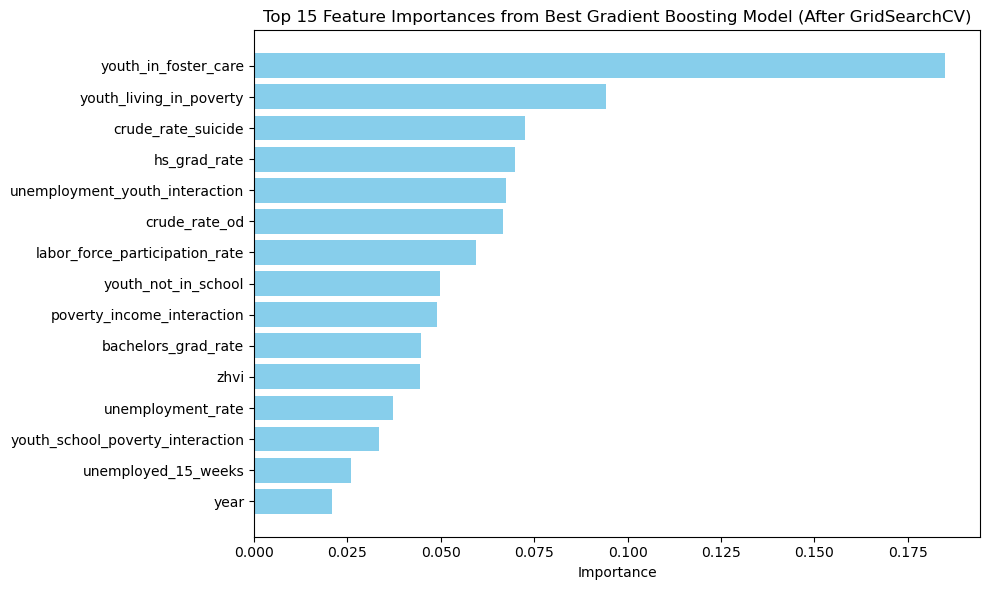

In [121]:

feature_importances = best_model.named_steps['gb'].feature_importances_

# Combine feature names and their corresponding importances
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances in a graph
plt.figure(figsize=(10, 6))

# Select the top 15 features for visualization
top_features = feature_importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances from Best Gradient Boosting Model (After GridSearchCV)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

plt.tight_layout()


------

###  XG Boosting

In [124]:
#https://xgboost.readthedocs.io/en/latest/python/sklearn_estimator.html

In [125]:
# Define the callback for early stopping
ss= StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc =ss.transform(X_test)
early_stop = xgb.callback.EarlyStopping(
    rounds=8,  # Stop after 2 rounds of no improvement
    metric_name='rmse',  # Change this to the metric you want to monitor
    data_name='validation_0',  # Corresponds to the eval_set name
    save_best=True
)

# Fit the XGBRegressor with early stopping callback
model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.1, 
    max_depth=5, 
    tree_method="hist",
    callbacks=[early_stop],
    random_state=42
)

# Define the evaluation set (validation)
eval_set = [(X_test_sc, y_test)]

# Fit the model with the early stopping callback
model.fit(
    X_train_sc, y_train,
    eval_set=eval_set,
    verbose=True,
      # Pass the early stopping callback
)

# Predict and evaluate
y_train_pred = model.predict(X_train_sc)
y_test_pred = model.predict(X_test_sc)

# Evaluating the model on training, validation, and testing sets
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train= r2_score(y_train, y_train_pred)


mse_test = mean_squared_error(y_test, y_test_pred)
mae_test= mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)


print("XG Boosting Model:")
print("Training MSE:", mse_train)
print("Training MAE:", mae_train)
print("Training R²:", r2_train)
print("Testing MSE:", mse_test)
print("Testing MAE:", mae_test)
print("Testing R²:", r2_test)



[0]	validation_0-rmse:1.14046
[1]	validation_0-rmse:1.08600
[2]	validation_0-rmse:1.05735
[3]	validation_0-rmse:1.02090
[4]	validation_0-rmse:1.00309
[5]	validation_0-rmse:0.98687
[6]	validation_0-rmse:0.97958
[7]	validation_0-rmse:0.96461
[8]	validation_0-rmse:0.94279
[9]	validation_0-rmse:0.93757
[10]	validation_0-rmse:0.92177
[11]	validation_0-rmse:0.90925
[12]	validation_0-rmse:0.89910
[13]	validation_0-rmse:0.88887
[14]	validation_0-rmse:0.88605
[15]	validation_0-rmse:0.87815
[16]	validation_0-rmse:0.87231
[17]	validation_0-rmse:0.86974
[18]	validation_0-rmse:0.87049
[19]	validation_0-rmse:0.86878
[20]	validation_0-rmse:0.87013
[21]	validation_0-rmse:0.87636
[22]	validation_0-rmse:0.87871
[23]	validation_0-rmse:0.87765
[24]	validation_0-rmse:0.88042
[25]	validation_0-rmse:0.88187
[26]	validation_0-rmse:0.88353
XG Boosting Model:
Training MSE: 0.1588072829229747
Training MAE: 0.28661813116289314
Training R²: 0.8691255362927361
Testing MSE: 0.7547826154375809
Testing MAE: 0.61731901

- The XGBoost model achieves a near-perfect fit on the training data but struggles with overfitting, as evidenced by the performance gap on the testing set. The model’s high complexity may be capturing noise in the training data, reducing its ability to generalize.



#### GridSearch XG Boosting

In [128]:
# Define the parameter grid
# Define parameter grid for hyperparameter tuning
# Pipeline setup
xg_pipeline = Pipeline(steps=[
    #('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, alpha=1.5))
])
param_grid = {
    'xgb__n_estimators': [100, 200,1000],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0],
    'xgb__lambda': [0, 1, 10],       # L2 regularization
    'xgb__alpha': [0, 0.5, 1]        # L1 regularization
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    xg_pipeline,
    param_grid=param_grid,
    cv=5,                             # 5-fold cross-validation
                    
    n_jobs=-1,                        # Use all available cores
   
)

# Fit GridSearchCV to the training data
# Fit with early stopping
grid_search.fit(
    X_train, y_train,
 
)


# Retrieve best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)
# Evaluate the best model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Grid Search XG Boosting Model:")
print("Best Parameters:", best_params)

print("Best Cross-Validated R²:", best_score)

print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Grid Search XG Boosting Model:
Best Parameters: {'xgb__alpha': 0, 'xgb__colsample_bytree': 0.8, 'xgb__lambda': 1, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 1000, 'xgb__subsample': 0.8}
Best Cross-Validated R²: 0.29183138185458246
Training MSE: 2.928066981547515e-07
Training MAE: 0.000432470570243654
Training R²: 0.9999997586954522
Testing MSE: 0.7532423964384951
Testing MAE: 0.593640792278971
Testing R²: 0.4669829095237443


- The Grid Search-tuned XGBoost model performs better on testing data compared to earlier versions, achieving a balance between fit on training data and generalization on the test set. The high training performance still points to some overfitting, but the testing R² of 0.55 indicates a stronger model fit than previous attempts.

In [130]:
early_stop = xgb.callback.EarlyStopping(
    rounds=8,  # Stop after 2 rounds of no improvement
    metric_name='rmse',  # Change this to the metric you want to monitor
    data_name='validation_0',  # Corresponds to the eval_set name
    save_best=True
)
best_params = {
    'alpha': 0,
    'colsample_bytree': 0.7,
    'lambda': 10,
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.9
}

# Initialize the XGBRegressor with best parameters
model = XGBRegressor(tree_method="hist", callbacks=[early_stop],random_state=42)
model.set_params(**best_params)

 
# Define the evaluation set (validation)
eval_set = [(X_test, y_test)]

# Fit the model with the early stopping callback
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False,
      # Pass the early stopping callback
)




# Predict on the training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate and print metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MSE:", train_mse)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing R²:", test_r2)

Training MSE: 0.07135926643319333
Training R²: 0.9411922076047505
Testing MSE: 0.7680785746539137
Testing R²: 0.45648438131614455


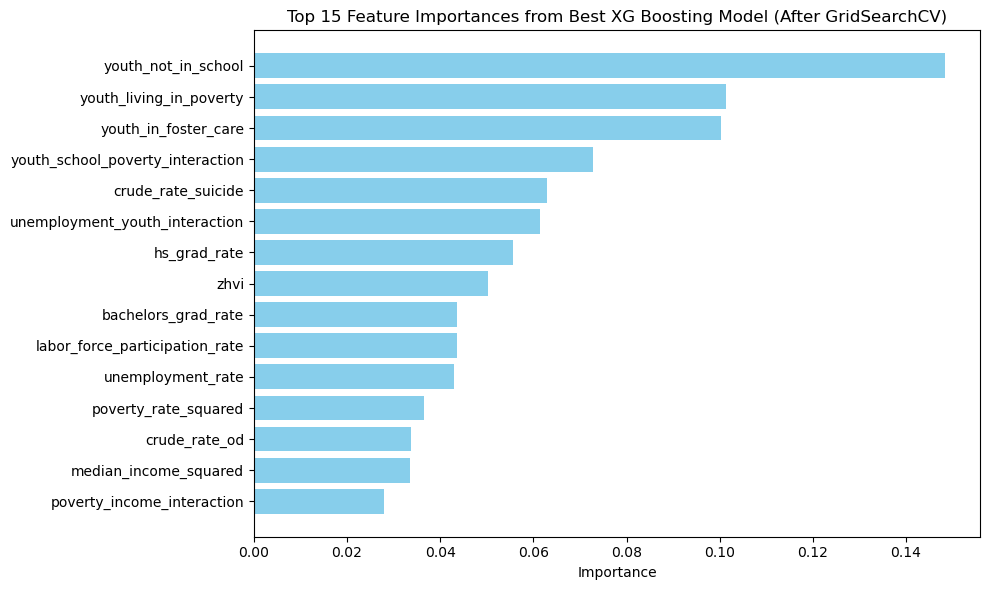

In [131]:
 #Get feature importances from the best model (Gradient Boosting)
feature_importances = best_model.named_steps['xgb'].feature_importances_

# Combine feature names and their corresponding importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances in a graph
plt.figure(figsize=(10, 6))
feature_importance_df.head(15)
# Select the top 15 features for visualization
top_features = feature_importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances from Best XG Boosting Model (After GridSearchCV)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

plt.tight_layout()


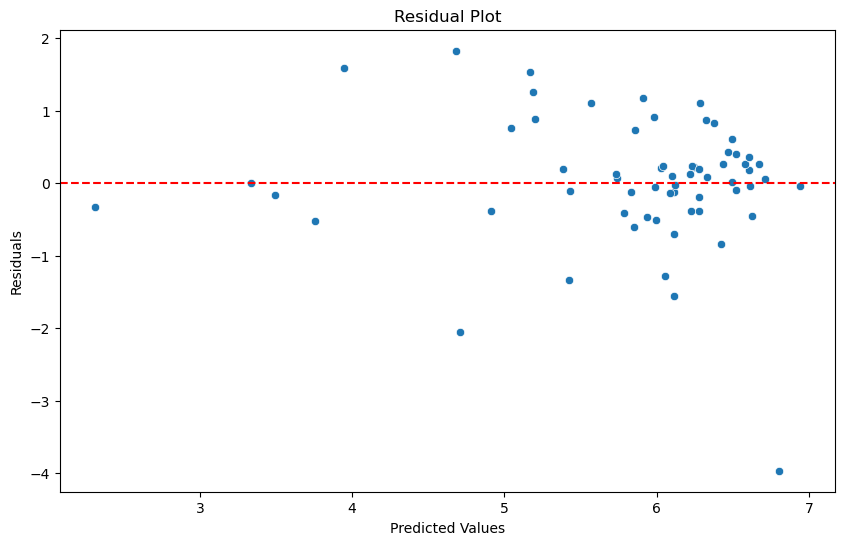

In [132]:

# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot');



----

### SVM

In [135]:


# Define the SVM pipeline with scaling
svm_pipeline = Pipeline([
    #('preprocessor', column_transformer),
    ('scaler', StandardScaler()),       # Scale features for SVR
    ('svr', SVR(kernel='linear',C=1.0, epsilon=0.1)   ) # Basic SVR model with default parameters
])


# Fit the pipeline on the training data
svm_pipeline.fit(X_train, y_train)

# Make predictions on training and testing sets

y_train_pred = svm_pipeline.predict(X_train)
y_test_pred = svm_pipeline.predict(X_test)

# Evaluate the model performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2_log = r2_score(y_test, y_test_pred)


print("SVM Model:")
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)


SVM Model:
Training MSE: 1.046149701529388
Training MAE: 0.5839125034158663
Training R²: 0.13785892797133525
Testing MSE: 1.9515822064516175
Testing MAE: 0.9118827975646934
Testing R²: 0.45648438131614455


- The SVM model appears to be underfitting, as it has a low R² on the training data but still performs moderately on the test set. This pattern suggests the model may lack complexity, as it fails to capture enough detail in the training data, leading to limited predictive power.

In [137]:
# Fit your model
X_train_df = pd.DataFrame(X_train, columns=X.columns)



# Access the coefficients (assuming SVR model in a regression task)
coefficients = svm_pipeline.named_steps['svr'].coef_[0]  # For SVR, coef_ is usually in a nested array

# If using LinearSVC for classification, the approach is similar:
# coefficients = svm_pipeline.named_steps['linear_svc'].coef_[0]

# Associate each coefficient with its corresponding feature name
features = X_train_df.columns  # Ensure this matches the columns input to the model after any preprocessing
feature_importance = pd.DataFrame(coefficients, index=features, columns=['Coefficient'])

# Display the feature importances
print(feature_importance.sort_values(by='Coefficient', ascending=False))


                                  Coefficient
youth_not_in_school                  0.598880
poverty_rate                         0.476255
median_income_squared                0.283112
crude_rate_suicide                   0.151955
unemployment_rate                    0.077329
youth_in_foster_care                 0.049866
hs_grad_rate                         0.027964
year                                 0.022657
bachelors_grad_rate                  0.012341
crude_rate_od                       -0.003518
youth_living_in_poverty             -0.035877
labor_force_participation_rate      -0.059872
unemployed_15_weeks                 -0.061910
youth_school_poverty_interaction    -0.103267
zhvi                                -0.105450
poverty_income_interaction          -0.126141
poverty_rate_squared                -0.260645
poverty_to_income_ratio             -0.343264
median_income                       -0.432143
unemployment_youth_interaction      -0.725149


#### GridSearch SVM

In [139]:



# Define the parameter grid for GridSearchCV
param_grid = {
    'svr__C': [0.1, 1, 10],              # Regularization strength
    'svr__epsilon': [0.01, 0.1, 0.5],    # Insensitivity margin
    'svr__kernel': ['linear', 'rbf']      # Kernels to test
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
# Make predictions with the best estimator on the test set
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred= grid_search.best_estimator_.predict(X_test)

# Evaluate the model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Grid Search SVM Model:")
print("Best Parameters:", best_params)
print("Best Cross-Validated R²:", best_score)

print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Grid Search SVM Model:
Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__kernel': 'rbf'}
Best Cross-Validated R²: 0.34858959658498245
Training MSE: 0.3083247086752257
Training MAE: 0.17053332982848735
Training R²: 0.7459069247149065
Testing MSE: 1.1245988094855532
Testing MAE: 0.6669244759300974
Testing R²: 0.20419988542958212


- The Grid Search-tuned SVM model shows improved fit on the training data, but the testing performance indicates some overfitting, with an R² of 0.21 on unseen data. This suggests that while the optimized model captures the training patterns better than before, it still struggles to generalize effectively.

----

### Stacking

In [143]:


# Define base models and meta model
base_models = [
    ('gradient_boosting', GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=500, random_state=42,min_samples_leaf= 1,min_samples_split= 5)),
    ('random_forest', RandomForestRegressor(ccp_alpha=0.1,n_estimators=50, max_depth=7,random_state=42,min_samples_leaf= 4,min_samples_split= 8)),
   ('lasso', Lasso(alpha=0.1, max_iter=10000))
]


meta_model = Ridge(alpha=1.0)


# Define the stacking regressor
stacked_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Create pipeline with stacking ensemble
stacking_pipeline = Pipeline(steps=[
    #('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('stacked_model', stacked_ensemble)
])

# Fit GridSearchCV on the training data to find the best parameters
stacking_pipeline.fit(X_train, y_train)


# Evaluate the stacked model on the test data
y_train_pred = stacking_pipeline.predict(X_train)
y_test_pred= stacking_pipeline.predict(X_test)

ensemble_train_score = stacking_pipeline.score(X_train, y_train)
ensemble_test_score = stacking_pipeline.score(X_test, y_test)

# Evaluate the model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


print("Stacking Model:")
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)





Stacking Model:
Training MSE: 0.21253070052058604
Training MAE: 0.3042531448369202
Training R²: 0.8248516003799922
Testing MSE: 0.8307624255631092
Testing MAE: 0.6537100963572434
Testing R²: 0.41212739346011784


- The Stacking model performs strongly, achieving high accuracy on the training data while retaining relatively good generalization on the test set. Although there’s a performance gap between training and testing metrics, the model does a better job of balancing fit and generalization.

----

### Bagging XGBoost

In [147]:


# Initialize XGBoost Regressor
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Set up Bagging with XGBoost as the base estimator
bagging_xgb = BaggingRegressor(
    estimator=xgb_regressor,
    n_estimators=10,          # Number of XGBoost models in the ensemble
    max_samples=0.8,          # Fraction of data used for each bootstrapped sample
    max_features=1.0,         # Fraction of features used for each model
    bootstrap=True,           # Bootstrapping samples
    n_jobs=-1,                # Use all processors
    random_state=42
)

# Train the bagging ensemble
bagging_xgb.fit(X_train, y_train)

# Make predictions

y_train_pred = stacking_pipeline.predict(X_train)
y_test_pred= stacking_pipeline.predict(X_test)


# Evaluate the model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print("Bagging XGBoost Model:")
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)



Bagging XGBoost Model:
Training MSE: 0.21253070052058604
Training MAE: 0.3042531448369202
Training R²: 0.8248516003799922
Testing MSE: 0.8307624255631092
Testing MAE: 0.6537100963572434
Testing R²: 0.41212739346011784


- The Bagging XGBoost model performs well, capturing much of the variance in the training set and showing a reasonable level of generalization on the test set. The R² score of 0.52 on testing data suggests that the model is more robust than individual models like standard XGBoost alone .

----

### Multi Target Regressor 

In [151]:

# Define features and target

# columns to exclude: population-related and crime-related features
crime_related_columns = [
    'count:__crimes_against_society', 
    'count:__fraud_and_other_financial_crimes', 
    'count:__property_crime', 
    'count:__violent_crime',
    'rate:__crimes_against_society', 
    'rate:__fraud_and_other_financial_crimes', 
    'rate:__property_crime', 
    'rate:__violent_crime',
    'total_crime_count',
    'total_crime_rate',
    'log_total_crime_rate'
]

population_related_columns = [
    #'total_pop',
    'white_pop',
    'black_pop',
    'hispanic_pop',
    'asian_pop',
    'native_pop',
    'islander_pop',
    'multi_race_pop',
    'state'
]

#features to keep: exclude population-related and crime-related features
#X = data.drop(columns=crime_related_columns + population_related_columns)
X = data.drop(columns=crime_related_columns + population_related_columns)

target_features = ['rate:__crimes_against_society', 
    'rate:__fraud_and_other_financial_crimes', 
    'rate:__property_crime', 
    'rate:__violent_crime']

X = data.drop(columns=crime_related_columns+population_related_columns )
y =np.log1p(data[target_features]) 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predic]ting multiple outputs
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# Evaluate the model
r_squared_each_output = r2_score(y_test, y_test_pred, multioutput='raw_values')
mse_each_output = mean_absolute_error(y_test, y_test_pred,multioutput='raw_values')
mae_each_output  = mean_squared_error(y_test, y_test_pred,multioutput='raw_values')


print("R^2 Score for each target:", r_squared_each_output)
print("MSE Score for each target:", mse_each_output)
print("MAE Score for each target:", mae_each_output)

R^2 Score for each target: [0.44362538 0.41936423 0.40388142 0.32726346]
MSE Score for each target: [0.68866607 0.57463132 0.61016184 0.64133528]
MAE Score for each target: [0.83106729 0.62625641 0.83283944 0.94299297]
